In [1]:
import numpy as np
from math import ceil,log,log10,sqrt,exp
import matplotlib.pyplot as plt
from scipy.stats import beta
import pandas as pd
import dill

In [2]:
# Saving & Loading Variables
filename = 'globalsave.pkl'
# dill.load_session(filename)

In [3]:
# for reproducibility
np.random.seed(1234)

In [4]:
# UCB Implementation given horizon (time steps), #replications, True arm means & Type of UCB algorithm
# For plotting average % Optimal arm pulls
def UCB(horizon,replications,arms_prob,ucbtype,optimalpulls):

    optimal_arm = 0

    optimal_arm_pulls_per_round = np.zeros([horizon,replications]) # Stores % optimal arm pulls for every time steps
    regret_per_round = np.zeros([horizon,replications]) # Stores regret for every time steps
    
    for r in range(replications):
        arm_means = [0]*len(arms_prob) # Initializing arm means & pulls to 0
        arm_pulls = [0]*len(arms_prob)
        t = 0
        #initially playing each arm once
        for i in range(len(arms_prob)):
            arm_pulls[i]+=1
            temp = np.random.binomial(1,arms_prob[i])
            arm_means[i] += (temp - arm_means[i])/arm_pulls[i] # Updating arm means estimate
            if optimalpulls == 'Avg':
                optimal_arm_pulls_per_round[t][r] = arm_pulls[optimal_arm]*100.0/(t+1) # Storing % optimal arm pulls at every time step
            else:
                if i == optimal_arm: # Incrementing % optimal arm pulls if current arm pulled is optimal arm
                    optimal_arm_pulls_per_round[t][r] += 1
            regret_per_round[t][r] = (arms_prob[optimal_arm] - arms_prob[i]) # Storing regret for every time step
            t+=1
            
        while t < horizon:
            #Picking arm according to UCB algorithm or UCB' algorithm
            if ucbtype == 1:
                UCBEstimate = arm_means + np.sqrt(2*np.log(t)/arm_pulls)
                arm_selected = np.argmax(UCBEstimate)
            else:
                UCBEstimate = arm_means + np.sqrt(2*np.log(horizon)/arm_pulls)
                arm_selected = np.argmax(UCBEstimate)

            arm_pulls[arm_selected] += 1
            temp = np.random.binomial(1, arms_prob[arm_selected]) # Updating arm means estimate
            arm_means[arm_selected] += (temp - arm_means[arm_selected]) /arm_pulls[arm_selected]
            regret_per_round[t][r] = (arms_prob[optimal_arm] - arms_prob[arm_selected]) # Storing regret for every time step
            if optimalpulls == 'Avg':
                optimal_arm_pulls_per_round[t][r] = arm_pulls[optimal_arm]*100.0/(t+1) # Storing % optimal arm pulls at every time step
            else:
                if arm_selected == optimal_arm: # Incrementing % optimal arm pulls if current arm pulled is optimal arm
                    optimal_arm_pulls_per_round[t][r] += 1
            t+=1


    # Calculating Mean and Standard Error for % optimal arm pulls
    optimal_arm_means_stderr = np.zeros([horizon,2]) # Store % optimal arm means & stderr in (horizion X 2) array
    optimal_arm_means_stderr[:,0] = np.mean(optimal_arm_pulls_per_round,axis=1)
    optimal_arm_means_stderr[:,1] = (np.std(optimal_arm_pulls_per_round, axis=1)/sqrt(replications))
    if optimalpulls == 'Avg':
        optimal_arm_percentage = sum(optimal_arm_means_stderr[:,0])/horizon
        optimal_arm_pulls_sum = np.mean(optimal_arm_pulls_per_round,axis=1)
    else:
        optimal_arm_percentage = sum(optimal_arm_means_stderr[:,0])/horizon*100
        optimal_arm_pulls_sum = np.cumsum(optimal_arm_means_stderr[:,0])/horizon*100
    print("\nTotal Optimal arm pulls :",sum(optimal_arm_means_stderr[:,0]),'and percentage is :',optimal_arm_percentage)



    # Calculating Mean and Standard Error for commulative regret
    regret_means_stderr = np.zeros([horizon,2]) # Store regret means & stderr in (horizion X 2) array
    regret_means_stderr[:,0] = np.mean(regret_per_round,axis=1)
    regret_means_stderr[:,1] = (np.std(regret_per_round, axis=1)/sqrt(replications))
    total_regret = sum(regret_means_stderr[:,0])
    regret_per_round_sum = np.cumsum(regret_means_stderr[:,0])
    print("Total Regret :",total_regret)


    return regret_per_round_sum,regret_means_stderr, optimal_arm_pulls_sum,optimal_arm_means_stderr,optimal_arm_percentage,total_regret



In [5]:
# Implemention Thompson Sampling
def TS(horizon,replications,arms_prob,alpha,beta,optimalpulls):
    optimal_arm = 0
    optimal_arm_pulls_per_round = np.zeros([horizon,replications])
    regret_per_round = np.zeros([horizon,replications])
    savepoints = (0,1000,5000,9999)
    success_ret = np.zeros([len(savepoints),len(arms_prob)])
    faliure_ret = np.zeros([len(savepoints),len(arms_prob)])
    
    for r in range(replications):
        arm_pulls = [0]*len(arms_prob)
        success = np.array(alpha)
        failure = np.array(beta)
        t = 0
        s = 0
        while t < horizon:
            if t in savepoints and r == replications-1:
                success_ret[s] = success
                faliure_ret[s] = failure
                s+=1
                
            #Picking arm according to Posterior distribution
            sample_means = [0]*len(arms_prob)
            for i in range(len(arms_prob)):
                sample_means[i] = np.random.beta(success[i],failure[i])
            arm_selected = np.argmax(sample_means)
            

            arm_pulls[arm_selected] += 1
            temp = np.random.binomial(1, arms_prob[arm_selected])
            success[arm_selected] += temp
            failure[arm_selected] += 1 - temp
            
            if optimalpulls == 'Avg':
                optimal_arm_pulls_per_round[t][r] = arm_pulls[optimal_arm]*100.0/(t+1)
            else:
                if arm_selected == optimal_arm: # Incrementing % optimal arm pulls if current arm pulled is optimal arm
                    optimal_arm_pulls_per_round[t][r] += 1
                    
            regret_per_round[t][r] = (arms_prob[optimal_arm] - arms_prob[arm_selected])
            
            t+=1


    # Calculating Mean and Standard Error for % optimal arm pulls
    optimal_arm_means_stderr = np.zeros([horizon,2])
    optimal_arm_means_stderr[:,0] = np.mean(optimal_arm_pulls_per_round,axis=1)
    optimal_arm_means_stderr[:,1] = (np.std(optimal_arm_pulls_per_round, axis=1)/sqrt(replications))
    
    if optimalpulls == 'Avg':
        optimal_arm_percentage = sum(optimal_arm_means_stderr[:,0])/horizon
        optimal_arm_pulls_sum = np.mean(optimal_arm_pulls_per_round,axis=1)
    else:
        optimal_arm_percentage = sum(optimal_arm_means_stderr[:,0])/horizon*100
        optimal_arm_pulls_sum = np.cumsum(optimal_arm_means_stderr[:,0])/horizon*100

    print("\nTotal Optimal arm pulls :",sum(optimal_arm_means_stderr[:,0]),'and percentage is :',optimal_arm_percentage)


    # Calculating Mean and Standard Error for commulative regret
    regret_means_stderr = np.zeros([horizon,2])
    regret_means_stderr[:,0] = np.mean(regret_per_round,axis=1)
    regret_means_stderr[:,1] = (np.std(regret_per_round, axis=1)/sqrt(replications))
    total_regret = sum(regret_means_stderr[:,0])
    regret_per_round_sum = np.cumsum(regret_means_stderr[:,0])
    print("Total Regret :",total_regret)


    return success_ret,faliure_ret,regret_per_round_sum,regret_means_stderr, optimal_arm_pulls_sum,optimal_arm_means_stderr,optimal_arm_percentage,total_regret


In [6]:
# Calculating Lower bound Regret
def calculate_lower_bound():
    arms_prob = [[0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], [0.5, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48], [0.5, 0.2, 0.1]]

    n = 10000
    gap_dependent_regret = np.zeros([3,n])
    gap_independent_regret = np.zeros([3,n])
    for i in range(3):
        k = len(arms_prob[i])
        for j in range(1,n):
            dep_reg = 0
            for g in range(len(arms_prob[i])):
                gap = arms_prob[i][0] - arms_prob[i][g]
                if gap > 0 and dep_reg >= 0:
                    dep_reg += log(j*gap**2)/(8*gap) #n*gap * exp(-4*j*gap**2/(k-1))/4 
                    if dep_reg < 0:
                        dep_reg = 0
            gap_dependent_regret[i][j] = dep_reg

            indep_reg = sqrt((k-1)*j/8)*exp(-1/2)/4
            gap_independent_regret[i][j] = indep_reg
    return gap_dependent_regret,gap_independent_regret


gap_dependent_regret,gap_independent_regret = calculate_lower_bound()

print('gap_dependent_regret')
print(gap_dependent_regret)

print('\ngap_independent_regret')
print(gap_independent_regret)

gap_dependent_regret
[[  0.           0.           0.         ...,  51.80478909  51.80591437
   51.80703954]
 [  0.           0.           0.         ...,  77.96218028  77.96780669
   77.97343253]
 [  0.           0.           0.         ...,   5.13966203   5.13973496
    5.13980789]]

gap_independent_regret
[[  0.           0.16083073   0.227449   ...,  16.0806602   16.08146446
   16.08226867]
 [  0.           0.16083073   0.227449   ...,  16.0806602   16.08146446
   16.08226867]
 [  0.           0.07581633   0.10722049 ...,   7.58049592   7.58087505
    7.58125416]]


In [7]:
# Plotting % Cummulative Optimal Arm Pulls Vs Time steps with error bars
def plotCumOptimalArmPulls(horizon,optimal_arm_means_stderr,optimal_arm_pulls_sum,problem,step):
    x = np.arange(horizon)
    ind = [i for i in range(0,horizon,step)]

    for i in range(m_len):
        plt.errorbar(x[ind],optimal_arm_pulls_sum[i,ind], optimal_arm_means_stderr[i,ind,1],
                    linestyle='-', marker='x',capsize=4,capthick=1.5,elinewidth=1.5)
    plt.xlabel('Steps')
    plt.ylabel('% Cummulative Optimal Arm Pulls')
    plt.legend(['UCB',"TS with prior mean=0.5","TS with prior mean=0.2"],loc=0,frameon=False)
    plt.title(arms_prob[problem])
    plt.xlim((0,10000))
    plt.ylim((0,100))
    plt.savefig('CummOptimalArmPulls_'+str(problem)+optimalpulls+'.png',dpi=300)
    plt.show()

    print("optimal_arm_stderr")
    print(optimal_arm_means_stderr[:,[500,2000,5000,8000,9500],1])



In [8]:
# Plotting % Average Optimal Arm Pulls Vs Time steps with error bars
def plotAvgOptimalArmPulls(horizon,optimal_arm_means_stderr,optimal_arm_pulls_sum,problem,step):
    x = np.arange(horizon)
    ind = [i for i in range(0,horizon,step)]

    for i in range(m_len):
        plt.errorbar(x[ind],optimal_arm_pulls_sum[i,ind], optimal_arm_means_stderr[i,ind,1],
                    linestyle='-', marker='x',capsize=4,capthick=1.5,elinewidth=1.5)
    plt.xlabel('Steps')
    plt.ylabel('% Average Optimal Arm Pulls')
    plt.legend(['UCB',"TS with prior mean=0.5","TS with prior mean=0.2"],loc=0,frameon=False)
    plt.title(arms_prob[problem])
    plt.xlim((0,10000))
    plt.ylim((0,100))
    plt.savefig('AvgOptimalArmPulls_'+str(problem)+optimalpulls+'.png',dpi=300)
    plt.show()

    print("optimal_arm_means_stderr")
    print(optimal_arm_means_stderr[:,[500,2000,5000,8000,9500],1])

In [9]:
# Plotting Cumulative Regret Vs Time steps with error bars
def plotCummRegret(horizon,regret_means_stderr,regret_per_round_sum,problem,step):
    labels = ["Gap-dependent lower bound","Gap-independent lower bound",'UCB',"TS with prior mean=0.5","TS with prior mean=0.2"]
    x = np.arange(horizon)
    ind = [i for i in range(0,horizon,step)]

    plt.plot(x[ind],gap_dependent_regret[problem][ind],label = labels[0])
    plt.plot(x[ind],gap_independent_regret[problem][ind],label = labels[1])
    
    for i in range(m_len):
        plt.errorbar(x[ind],regret_per_round_sum[i,ind], regret_means_stderr[i,ind,1],label = labels[i+2],
                linestyle='-', marker='x',capsize=4,capthick=1.5,elinewidth=1.5)

    plt.xlabel('Steps')
    plt.ylabel('Cumulative Regret')
    plt.legend(loc=0,frameon=False)
    plt.title(arms_prob[problem])
    plt.xlim((0,10000))
#     plt.ylim((0,80))
    plt.savefig('CumulativeRegret_'+str(problem)+optimalpulls+'.png',dpi=300)
    plt.show()

    print("regret_means_stderr")
    print(regret_means_stderr[:,[500,2000,5000,8000,9500],1])
    print("regret_per_round_sum")
    print(regret_per_round_sum[:,[500,2000,5000,8000,9500]])
    print("gap_dependent_regret")
    print(gap_dependent_regret[problem,[500,2000,5000,8000,9500]])
    print("gap_independent_regret")
    print(gap_independent_regret[problem,[500,2000,5000,8000,9500]])


In [10]:
def plot_arm_distribution(alpha_values,beta_values):
    
    savepoints = [1,1000,5000,10000]
    s = 0
    for p in range(len(alpha_values)):
        
        fig, ax = plt.subplots(figsize=(10, 6))
        m = alpha_values[p] / (alpha_values[p] + beta_values[p])
        print("Mean at time t = "+str(savepoints[s])+" is: ",m)

        x = np.linspace(0, 1, 1000)[1:-1]
        i = 1
        for a, b in zip(alpha_values[p], beta_values[p]):
            plt.plot(x, beta.pdf(x,a,b),
                     label=r'Arm %d : $\alpha=%d,\ \beta=%d$' % (i, a, b))
            i+=1

        plt.ylim(0, 20)
        plt.xticks(np.arange(0, 1.1,0.1))
        plt.xlabel(r'$ \theta $')
        plt.ylabel(r'$p(\theta|\alpha,\beta)$')
        plt.title('Problem '+str(problem+1)+' at t = '+str(savepoints[s]))
        s+=1
        plt.legend(loc=0)
        plt.savefig('Arm_dist_t_'+str(savepoints[s-1])+'_'+str(problem+1)+'_'+optimalpulls+'.png',dpi=300)
        plt.show()
    

In [11]:
# For Printing table
from IPython.display import HTML, display

def tableIt(data):
    print(pd.DataFrame(data))



Total Optimal arm pulls : 283612.675268 and percentage is : 28.3612675268
Total Regret : 593.993

Total Optimal arm pulls : 652499.168408 and percentage is : 65.2499168408
Total Regret : 163.781

Total Optimal arm pulls : 683731.231325 and percentage is : 68.3731231325
Total Regret : 145.473


optimal_arm_percentage
           0
0  28.361268
1  65.249917
2  68.373123


total_regret
         0
0  593.993
1  163.781
2  145.473


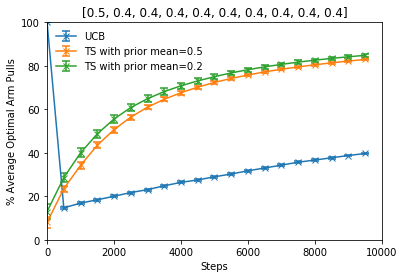

optimal_arm_means_stderr
[[ 0.37932051  0.43692854  0.44865863  0.45474807  0.435826  ]
 [ 1.37482323  1.32860494  0.6824189   0.44764855  0.38093131]
 [ 2.01556859  1.74196148  1.1765315   0.72305736  0.6041692 ]]


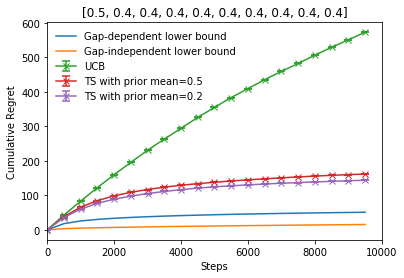

regret_means_stderr
[[ 0.00324962  0.00392301  0.00497494  0.00491833  0.00462493]
 [ 0.00448999  0.00384187  0.00255147  0.00099499  0.00099499]
 [ 0.00495076  0.00420833  0.00237487  0.00217945  0.00255147]]
regret_per_round_sum
[[  42.736  160.02   355.174  506.605  572.967]
 [  38.318   98.747  138.166  156.021  161.991]
 [  35.768   88.902  124.882  139.08   144.003]]
gap_dependent_regret
[ 18.10617651  33.70198808  44.01025881  49.29779964  51.23111503]
gap_independent_regret
[  3.59628442   7.19256883  11.37244987  14.38513767  15.67584034]
Mean at time t = 1 is:  [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]


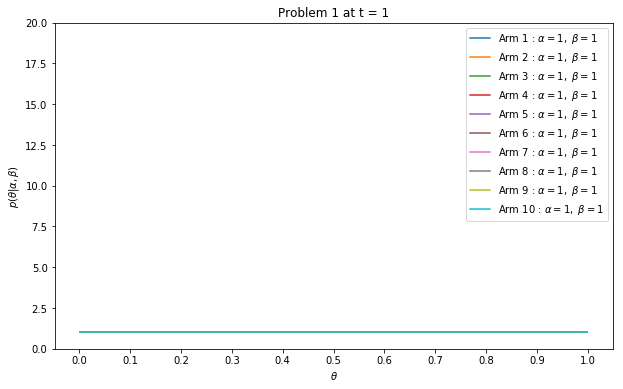

Mean at time t = 1000 is:  [ 0.52199413  0.34693878  0.30769231  0.38636364  0.45833333  0.44594595
  0.44444444  0.46551724  0.39344262  0.44444444]


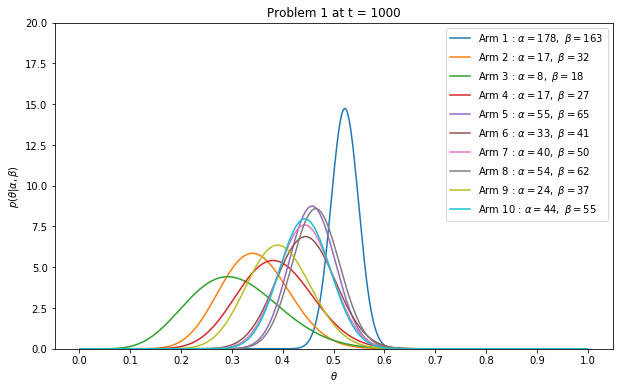

Mean at time t = 5000 is:  [ 0.50935213  0.33898305  0.4109589   0.39772727  0.46850394  0.41666667
  0.42245989  0.43809524  0.42285714  0.41176471]


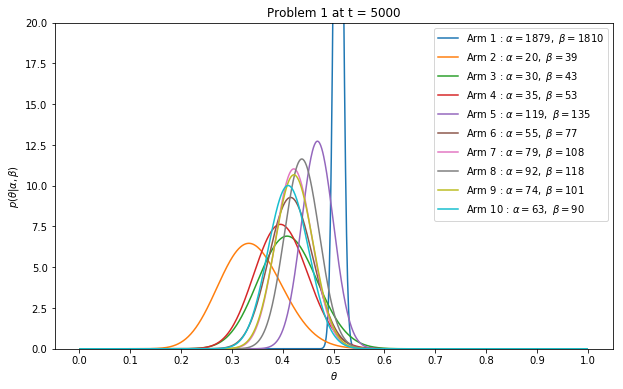

Mean at time t = 10000 is:  [ 0.50435757  0.34883721  0.37        0.38655462  0.45081967  0.40526316
  0.42205323  0.41666667  0.41803279  0.42801556]


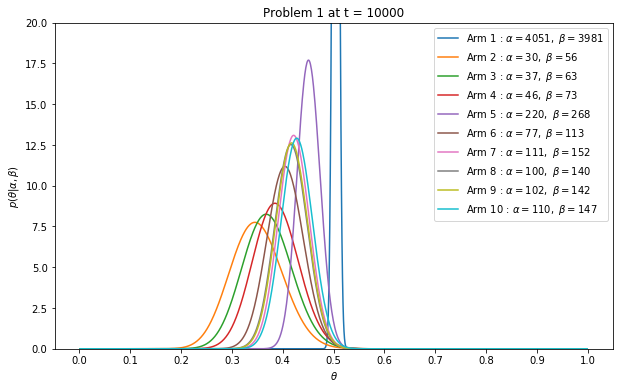

Mean at time t = 1 is:  [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]


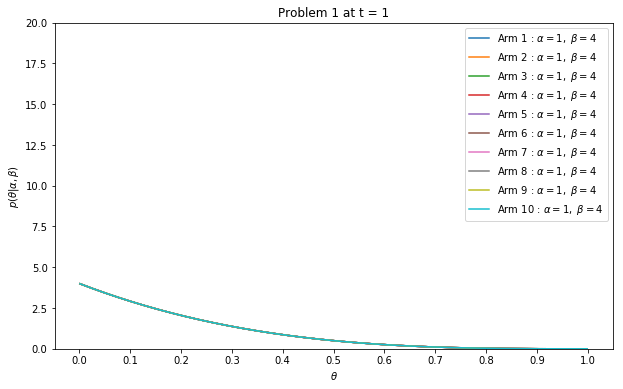

Mean at time t = 1000 is:  [ 0.49002217  0.3902439   0.31034483  0.1         0.32        0.34848485
  0.41578947  0.39735099  0.09090909  0.1       ]


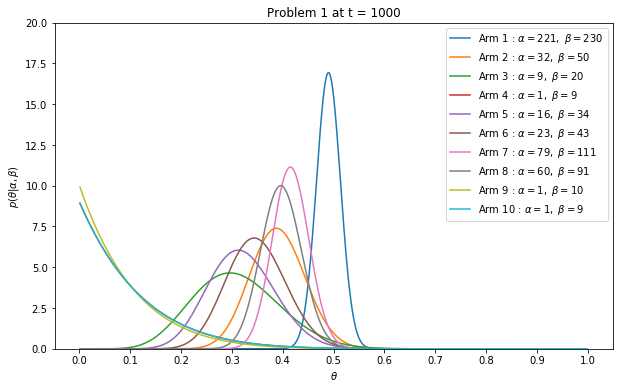

Mean at time t = 5000 is:  [ 0.48611867  0.36419753  0.26415094  0.42937853  0.40888889  0.38571429
  0.40718563  0.40677966  0.17647059  0.25      ]


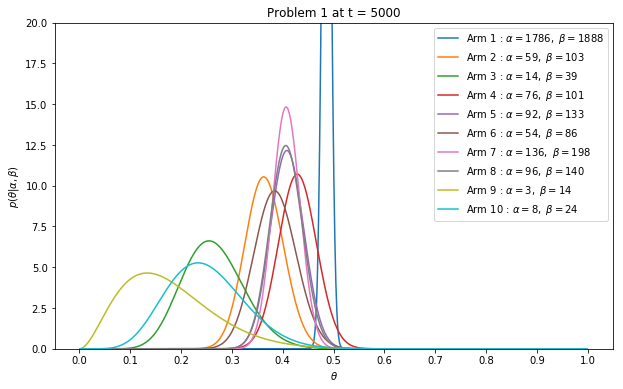

Mean at time t = 10000 is:  [ 0.49659624  0.36144578  0.26415094  0.40756303  0.41698842  0.39634146
  0.40895522  0.4140625   0.19047619  0.24324324]


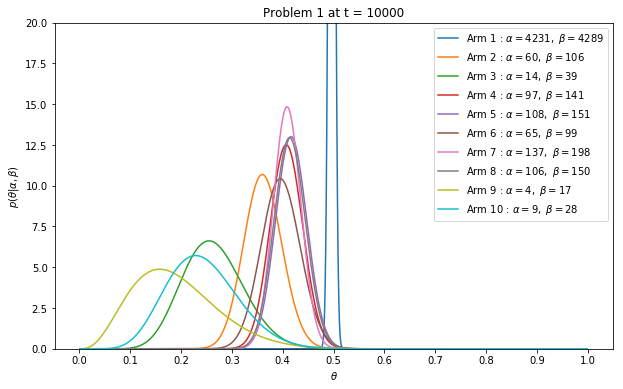


Total Optimal arm pulls : 120911.777501 and percentage is : 12.0911777501
Total Regret : 173.3864

Total Optimal arm pulls : 186662.859336 and percentage is : 18.6662859336
Total Regret : 151.8254

Total Optimal arm pulls : 184985.5294 and percentage is : 18.49855294
Total Regret : 151.7754


optimal_arm_percentage
           0
0  12.091178
1  18.666286
2  18.498553


total_regret
          0
0  173.3864
1  151.8254
2  151.7754


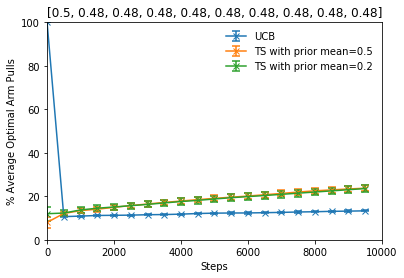

optimal_arm_means_stderr
[[ 0.28318001  0.28274657  0.29367604  0.30803299  0.30607703]
 [ 0.85373802  1.1549887   1.30079714  1.3876149   1.41370241]
 [ 1.26060158  1.35384415  1.46942818  1.54023541  1.56892188]]


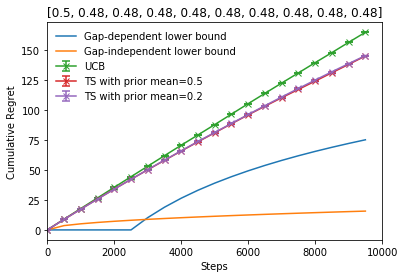

regret_means_stderr
[[ 0.00069397  0.00043589  0.00064992  0.00071414  0.00069397]
 [ 0.00071414  0.00084167  0.00081462  0.00092499  0.00094742]
 [ 0.00073321  0.0008      0.00084167  0.00091652  0.00096   ]]
regret_per_round_sum
[[   8.952    35.5116   87.7602  139.3692  164.7034]
 [   8.807    34.0506   80.9434  123.9802  144.9186]
 [   8.7878   33.9774   81.2388  124.8678  145.241 ]]
gap_dependent_regret
[  0.           0.          38.98952891  65.42723305  75.09381   ]
gap_independent_regret
[  3.59628442   7.19256883  11.37244987  14.38513767  15.67584034]
Mean at time t = 1 is:  [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]


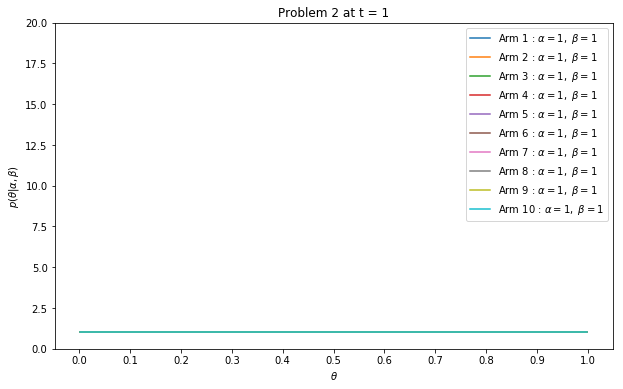

Mean at time t = 1000 is:  [ 0.51485149  0.35483871  0.524       0.44594595  0.515625    0.30434783
  0.46666667  0.36666667  0.46590909  0.49      ]


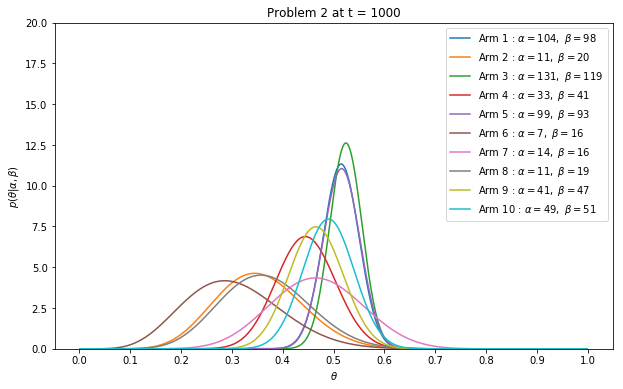

Mean at time t = 5000 is:  [ 0.51424361  0.38666667  0.49730216  0.44444444  0.47184987  0.31707317
  0.47193878  0.31707317  0.47493404  0.47188264]


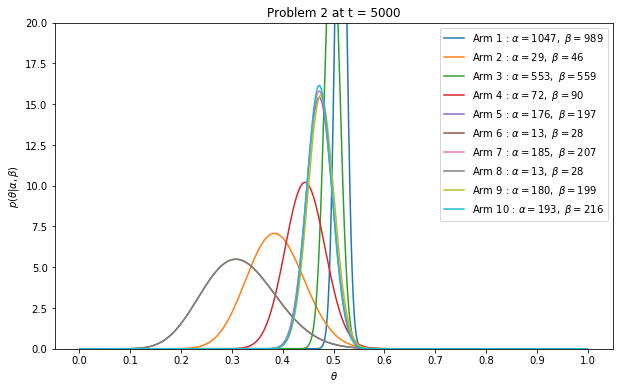

Mean at time t = 10000 is:  [ 0.51450163  0.41558442  0.49598624  0.43220339  0.47201493  0.49282297
  0.47684391  0.38372093  0.4745098   0.47758887]


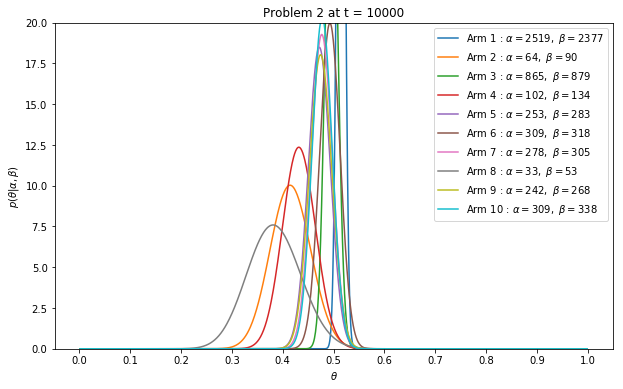

Mean at time t = 1 is:  [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]


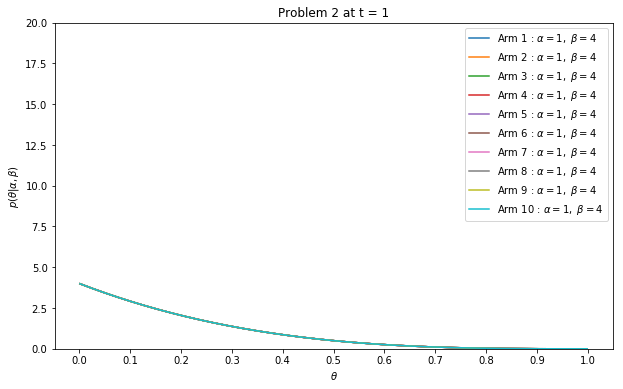

Mean at time t = 1000 is:  [ 0.50588235  0.52631579  0.25        0.47849462  0.31578947  0.23529412
  0.18181818  0.41666667  0.32142857  0.1       ]


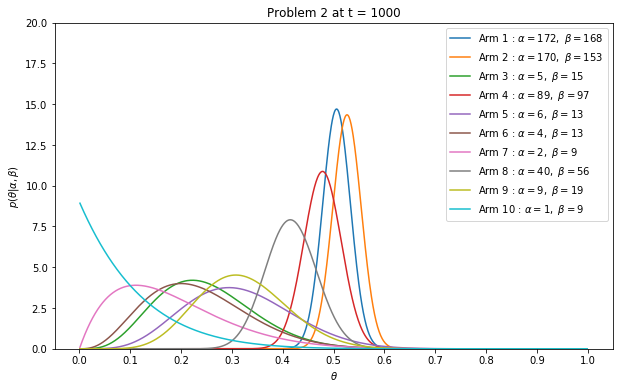

Mean at time t = 5000 is:  [ 0.51336717  0.4853114   0.40425532  0.44023324  0.47540984  0.2
  0.13333333  0.50196078  0.4198895   0.23076923]


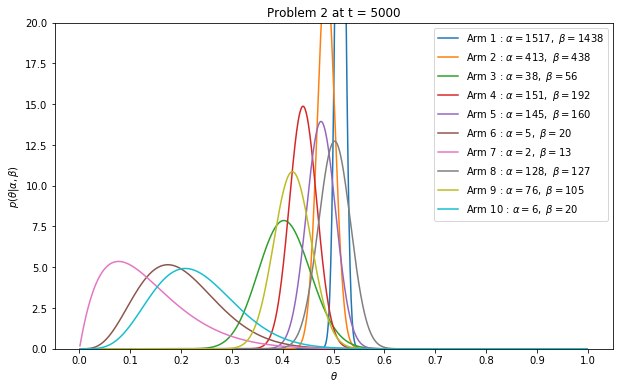

Mean at time t = 10000 is:  [ 0.49947424  0.48360656  0.38970588  0.45631068  0.47182176  0.30232558
  0.11764706  0.48771121  0.45733788  0.28571429]


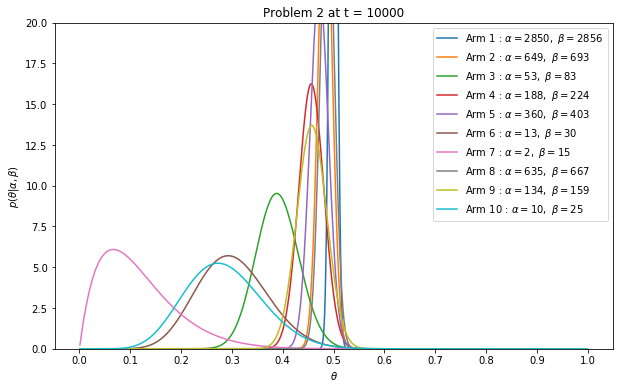


Total Optimal arm pulls : 934693.661168 and percentage is : 93.4693661168
Total Regret : 83.607

Total Optimal arm pulls : 980563.54202 and percentage is : 98.056354202
Total Regret : 16.274

Total Optimal arm pulls : 984437.531967 and percentage is : 98.4437531967
Total Regret : 12.754


optimal_arm_percentage
           0
0  93.469366
1  98.056354
2  98.443753


total_regret
        0
0  83.607
1  16.274
2  12.754


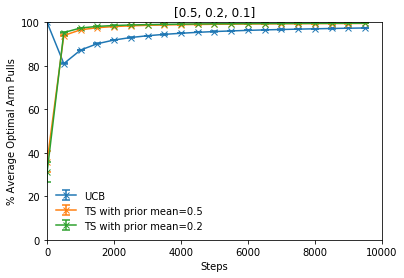

optimal_arm_means_stderr
[[ 0.30812797  0.11263889  0.05128719  0.03391501  0.02926298]
 [ 0.32196661  0.0802825   0.03251039  0.02044813  0.01726094]
 [ 0.29373779  0.07279044  0.02945255  0.01821061  0.01522703]]


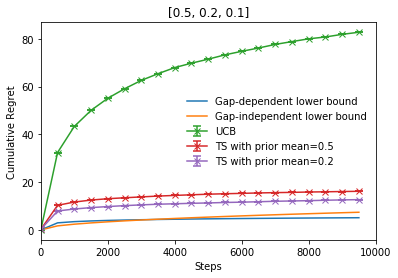

regret_means_stderr
[[ 0.00964365  0.00397995  0.00397995  0.00298496  0.00298496]
 [ 0.00298496  0.00298496  0.          0.          0.        ]
 [ 0.00298496  0.          0.          0.          0.        ]]
regret_per_round_sum
[[ 32.377  55.085  71.444  79.962  82.712]
 [ 10.293  13.056  14.944  15.859  16.159]
 [  7.919   9.769  11.291  12.24   12.671]]
gap_dependent_regret
[ 2.95549269  3.96633233  4.63446099  4.97717197  5.10247945]
gap_independent_regret
[ 1.69530473  3.39060946  5.36102428  6.78121893  7.38966201]
Mean at time t = 1 is:  [ 0.5  0.5  0.5]


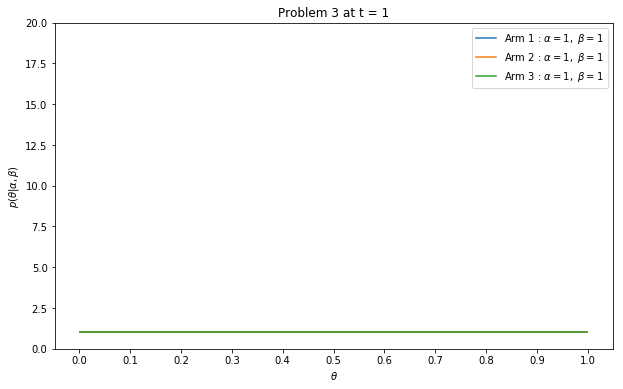

Mean at time t = 1000 is:  [ 0.49693252  0.13333333  0.15384615]


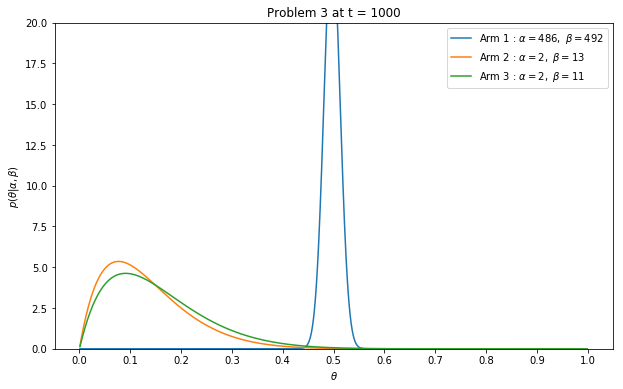

Mean at time t = 5000 is:  [ 0.49728316  0.11764706  0.15      ]


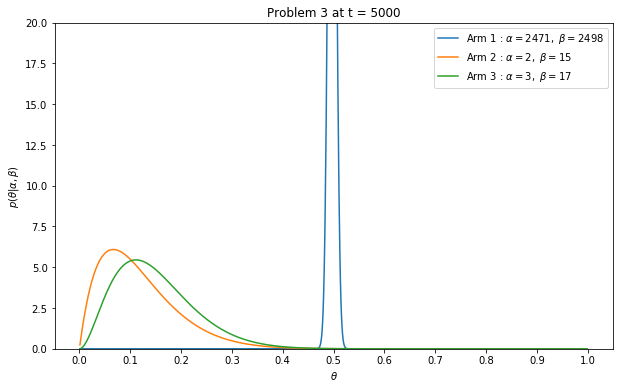

Mean at time t = 10000 is:  [ 0.50060205  0.11111111  0.14285714]


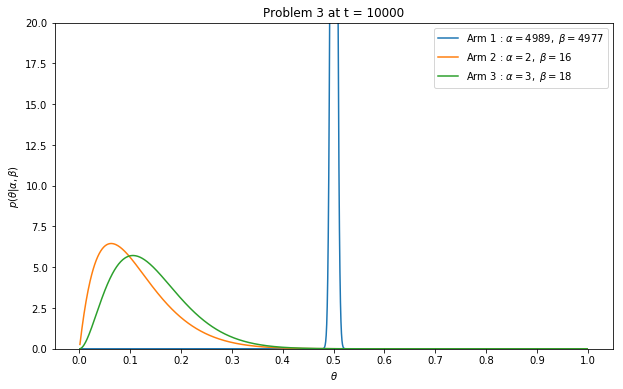

Mean at time t = 1 is:  [ 0.2  0.2  0.2]


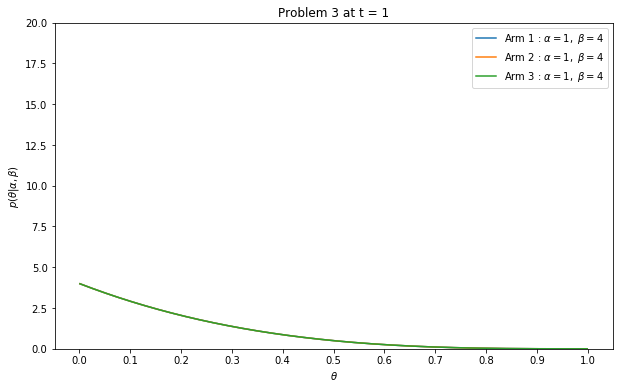

Mean at time t = 1000 is:  [ 0.50907258  0.1         0.15384615]


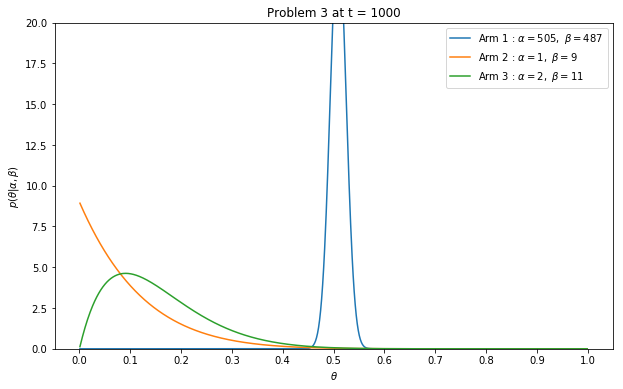

Mean at time t = 5000 is:  [ 0.50391802  0.11764706  0.14285714]


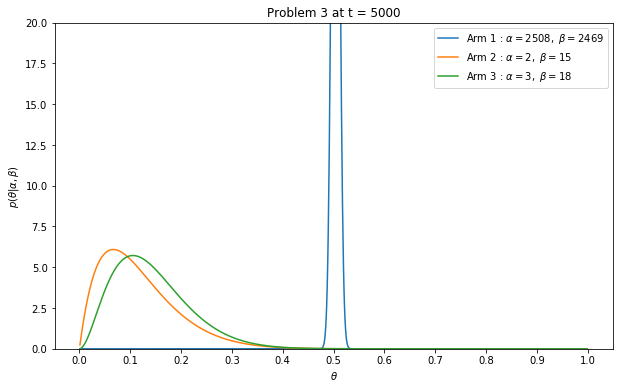

Mean at time t = 10000 is:  [ 0.50365915  0.11111111  0.14285714]


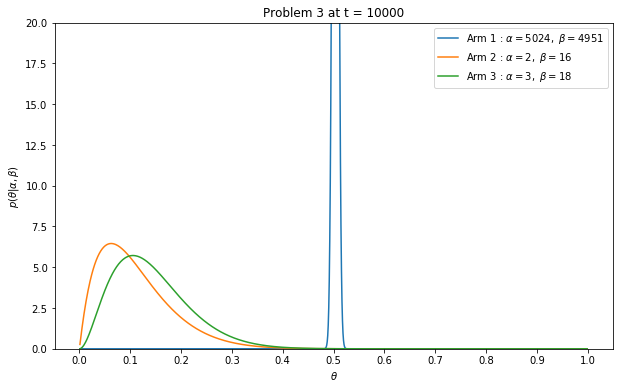

In [12]:
horizon = 10000
replications = 100

arms_prob = [[0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], [0.5, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48], [0.5, 0.2, 0.1]]
types = ['UCB','TS M0.5','TS M0.2']
m_len = len(types)
success = [1,1]
failure = [1,4]
optimalpulls = 'Avg'

for problem in range(3): # Repeating for 3 problems
    optimal_arm_pulls_sum = np.zeros([m_len,horizon]) # Storing variables returned by UCB function
    regret_per_round_sum = np.zeros([m_len,horizon])
    optimal_arm_means_stderr = np.zeros([m_len,horizon,2])
    regret_means_stderr = np.zeros([m_len,horizon,2])
    optimal_arm_percentage = np.zeros([m_len])
    total_regret = np.zeros([m_len])
    success_ret = np.zeros([2,4,len(arms_prob[problem])])
    failure_ret = np.zeros([2,4,len(arms_prob[problem])])


    regret_per_round_sum[0,:],regret_means_stderr[0,:,:], optimal_arm_pulls_sum[0,:],optimal_arm_means_stderr[0,:,:],optimal_arm_percentage[0],total_regret[0] = UCB(horizon,replications,arms_prob[problem],1,optimalpulls)
    success_ret[0,:,:],failure_ret[0,:,:],regret_per_round_sum[1,:],regret_means_stderr[1,:,:], optimal_arm_pulls_sum[1,:],optimal_arm_means_stderr[1,:,:],optimal_arm_percentage[1],total_regret[1] = TS(horizon,replications,arms_prob[problem],[success[0]]*len(arms_prob[problem]),[failure[0]]*len(arms_prob[problem]),optimalpulls)
    success_ret[1,:,:],failure_ret[1,:,:],regret_per_round_sum[2,:],regret_means_stderr[2,:,:], optimal_arm_pulls_sum[2,:],optimal_arm_means_stderr[2,:,:],optimal_arm_percentage[2],total_regret[2] = TS(horizon,replications,arms_prob[problem],[success[1]]*len(arms_prob[problem]),[failure[1]]*len(arms_prob[problem]),optimalpulls)
    


    step = 500
    print("\n")
    print("optimal_arm_percentage")
    tableIt(optimal_arm_percentage)
    print("\n")
    print("total_regret")
    tableIt(total_regret)

    # Calling function to plot % Average Optimal Arm Pulls & Commulative regret with error bars
    plotAvgOptimalArmPulls(horizon,optimal_arm_means_stderr,optimal_arm_pulls_sum,problem,step)
    plotCummRegret(horizon,regret_means_stderr,regret_per_round_sum,problem,step)
    plot_arm_distribution(success_ret[0],failure_ret[0])
    plot_arm_distribution(success_ret[1],failure_ret[1])
    


Total Optimal arm pulls : 4085.01 and percentage is : 40.8501
Total Regret : 591.499

Total Optimal arm pulls : 8373.46 and percentage is : 83.7346
Total Regret : 162.654

Total Optimal arm pulls : 8530.6 and percentage is : 85.306
Total Regret : 146.94


optimal_arm_percentage
         0
0  40.8501
1  83.7346
2  85.3060


total_regret
         0
0  591.499
1  162.654
2  146.940


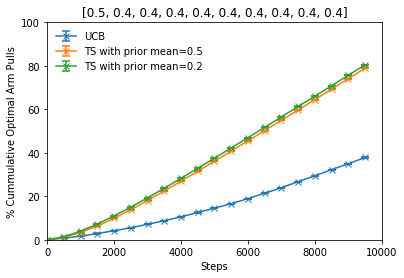

optimal_arm_stderr
[[ 0.03249615  0.04439595  0.04918333  0.04828043  0.04950758]
 [ 0.04737088  0.04439595  0.02179449  0.02179449  0.01705872]
 [ 0.04877499  0.03756328  0.02712932  0.00994987  0.01959592]]
Mean at time t = 1 is:  [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]


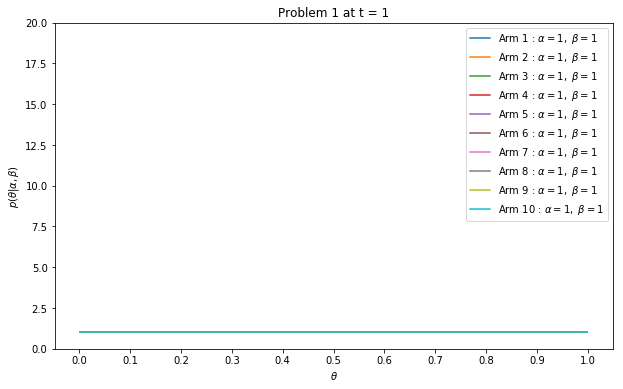

Mean at time t = 1000 is:  [ 0.49578059  0.44615385  0.32142857  0.30232558  0.28571429  0.39230769
  0.26666667  0.35135135  0.25        0.2       ]


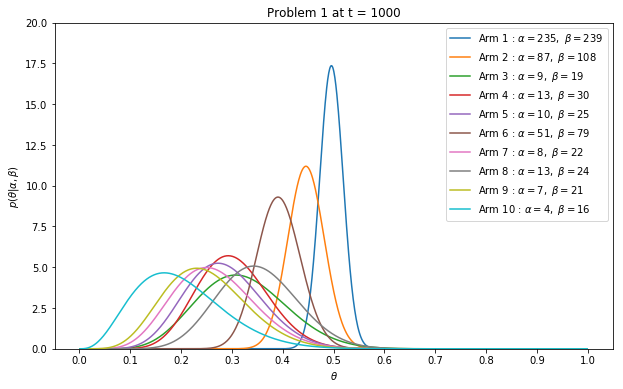

Mean at time t = 5000 is:  [ 0.49002101  0.43413174  0.38709677  0.3375      0.28571429  0.38255034
  0.27272727  0.43362832  0.21875     0.38043478]


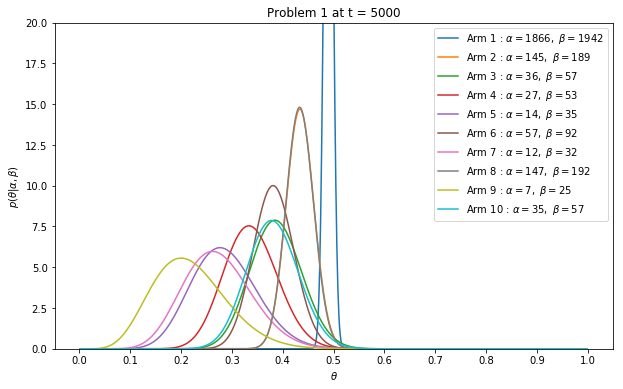

Mean at time t = 10000 is:  [ 0.49940688  0.42465753  0.44290657  0.32941176  0.28        0.37662338
  0.25531915  0.43089431  0.24390244  0.4021164 ]


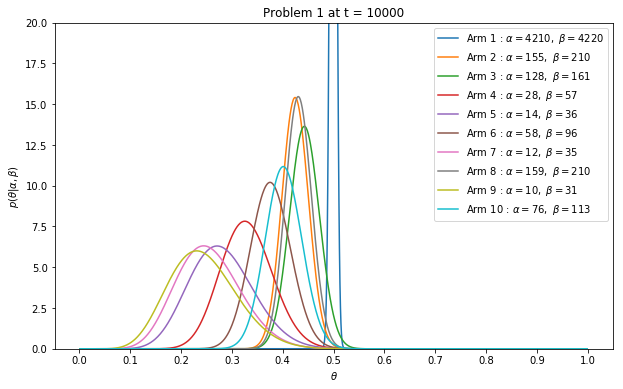

Mean at time t = 1 is:  [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]


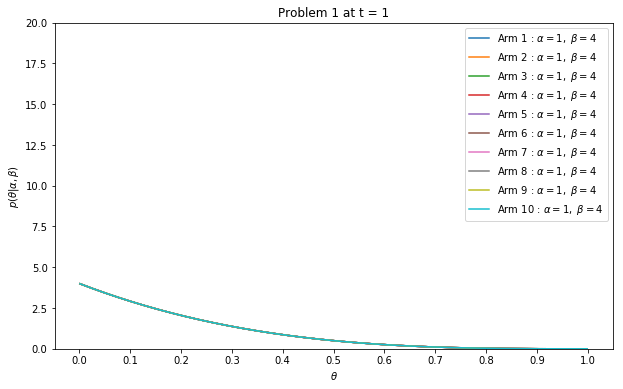

Mean at time t = 1000 is:  [ 0.3877551   0.3125      0.36507937  0.27906977  0.25714286  0.1
  0.43595041  0.40340909  0.37349398  0.23076923]


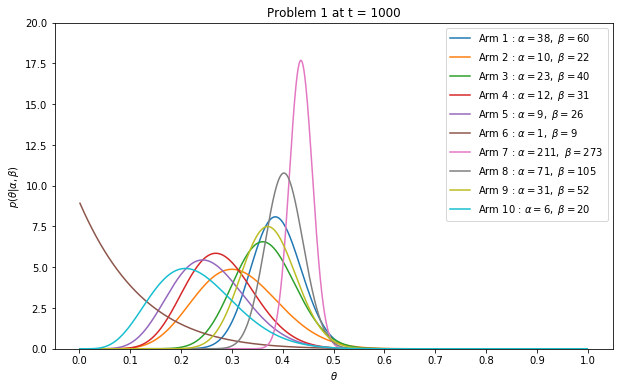

Mean at time t = 5000 is:  [ 0.49939976  0.39181287  0.37606838  0.2962963   0.36507937  0.43699732
  0.42495479  0.40692641  0.37007874  0.20689655]


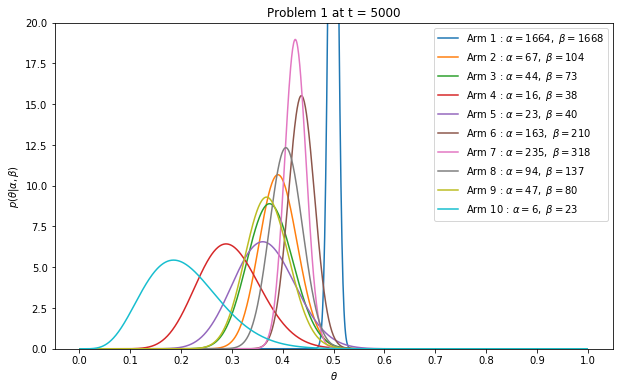

Mean at time t = 10000 is:  [ 0.49506435  0.38709677  0.3961039   0.28070175  0.42965779  0.44180523
  0.42576029  0.39583333  0.37956204  0.20689655]


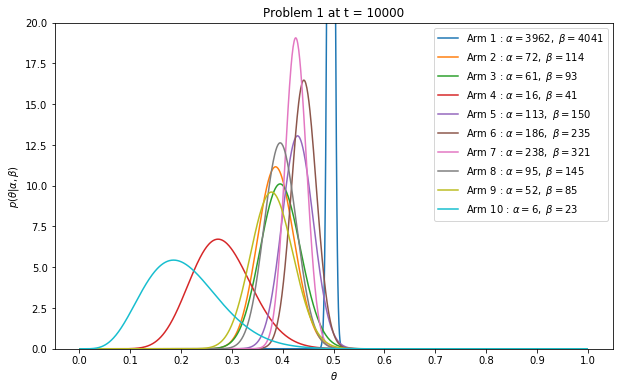


Total Optimal arm pulls : 1351.15 and percentage is : 13.5115
Total Regret : 172.977

Total Optimal arm pulls : 2266.69 and percentage is : 22.6669
Total Regret : 154.6662

Total Optimal arm pulls : 2225.47 and percentage is : 22.2547
Total Regret : 155.4906


optimal_arm_percentage
         0
0  13.5115
1  22.6669
2  22.2547


total_regret
          0
0  172.9770
1  154.6662
2  155.4906


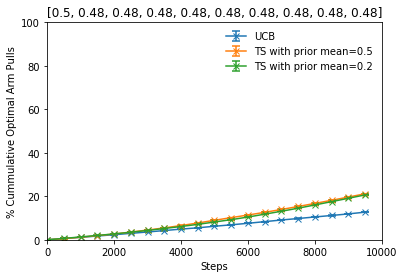

optimal_arm_stderr
[[ 0.03        0.03249615  0.03666061  0.0346987   0.03570714]
 [ 0.03249615  0.04        0.04702127  0.04439595  0.04624932]
 [ 0.03        0.03128898  0.04208325  0.04828043  0.04582576]]
Mean at time t = 1 is:  [ 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5]


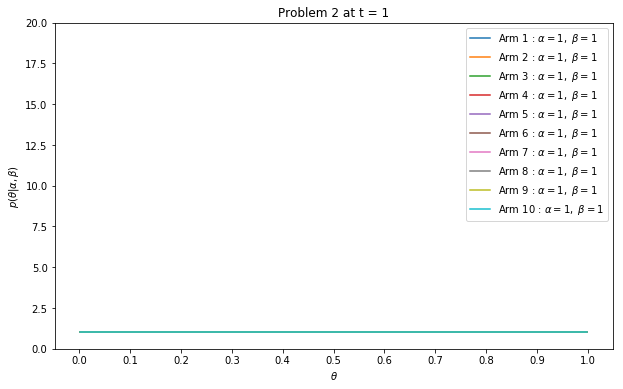

Mean at time t = 1000 is:  [ 0.41666667  0.48979592  0.484375    0.14285714  0.48192771  0.49473684
  0.125       0.54397394  0.50485437  0.42307692]


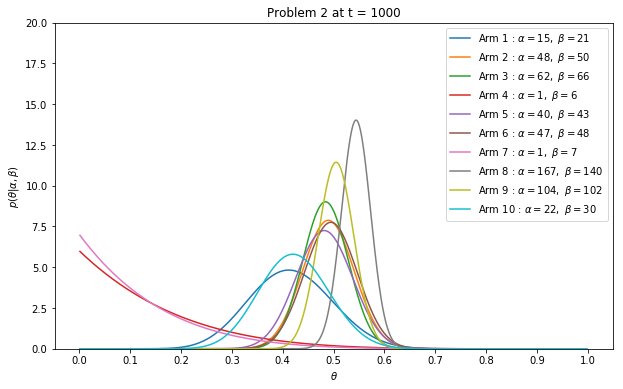

Mean at time t = 5000 is:  [ 0.53886616  0.48070175  0.45495495  0.35849057  0.46808511  0.5
  0.42352941  0.51771117  0.5106383   0.40196078]


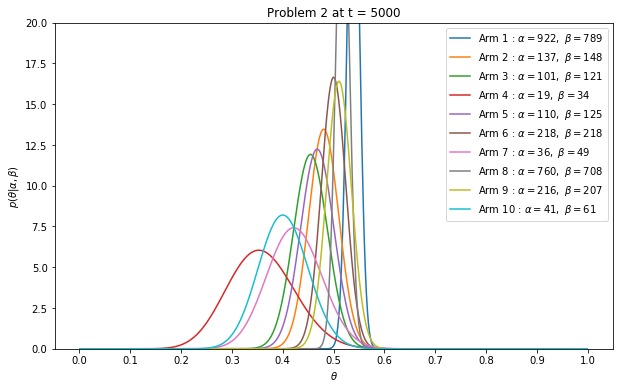

Mean at time t = 10000 is:  [ 0.51920744  0.47954545  0.46179402  0.41836735  0.48235294  0.4915493
  0.46927374  0.49976202  0.47916667  0.42857143]


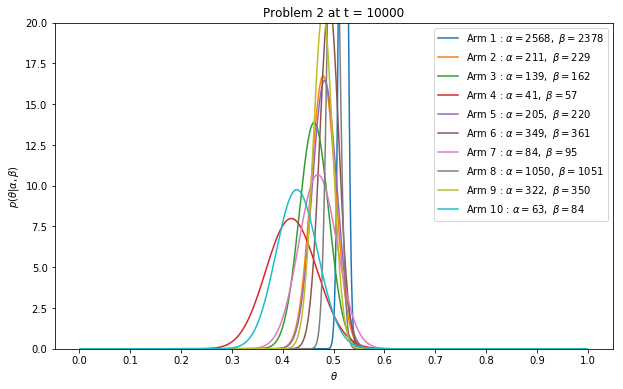

Mean at time t = 1 is:  [ 0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2  0.2]


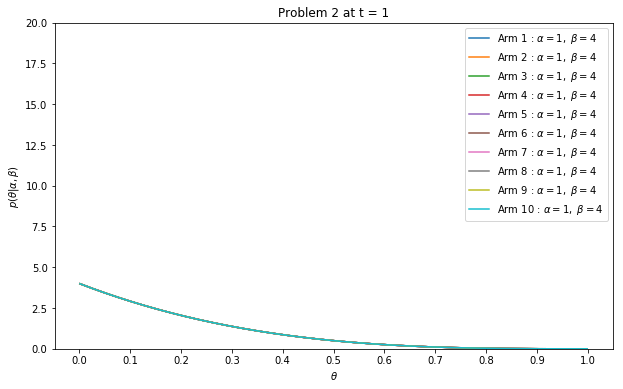

Mean at time t = 1000 is:  [ 0.47852761  0.33333333  0.53527981  0.32258065  0.46788991  0.18181818
  0.42424242  0.53465347  0.41025641  0.48421053]


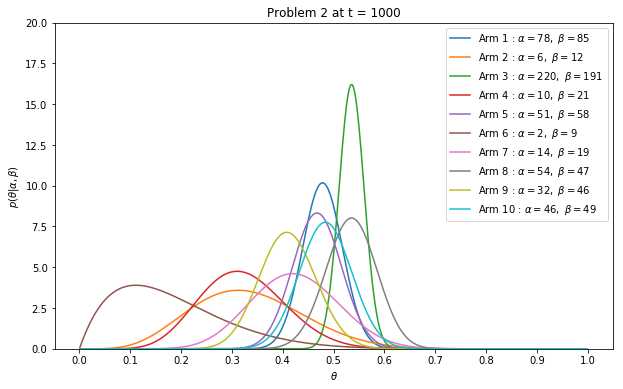

Mean at time t = 5000 is:  [ 0.49255751  0.31428571  0.48929664  0.49479941  0.47147147  0.2173913
  0.42307692  0.49968691  0.37383178  0.47044335]


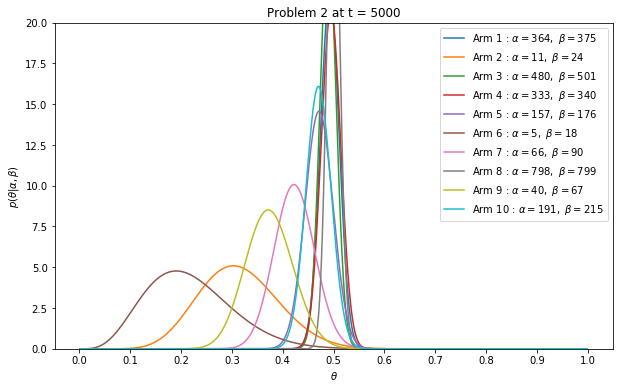

Mean at time t = 10000 is:  [ 0.49607623  0.33333333  0.47994467  0.48519219  0.48195576  0.19230769
  0.45983936  0.49320794  0.38095238  0.4754717 ]


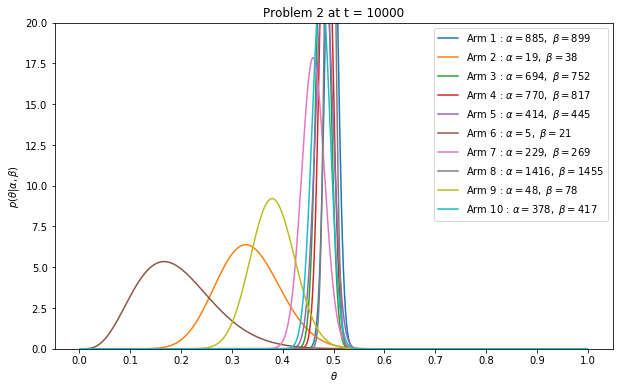


Total Optimal arm pulls : 9749.23 and percentage is : 97.4923
Total Regret : 84.45

Total Optimal arm pulls : 9952.5 and percentage is : 99.525
Total Regret : 16.055

Total Optimal arm pulls : 9963.59 and percentage is : 99.6359
Total Regret : 12.261


optimal_arm_percentage
         0
0  97.4923
1  99.5250
2  99.6359


total_regret
        0
0  84.450
1  16.055
2  12.261


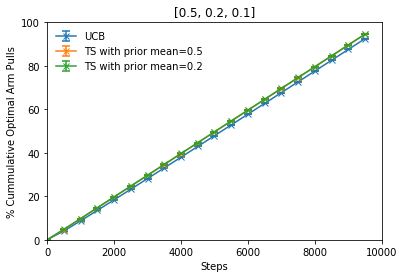

optimal_arm_stderr
[[ 0.01705872  0.01959592  0.          0.00994987  0.014     ]
 [ 0.00994987  0.          0.          0.          0.        ]
 [ 0.00994987  0.00994987  0.          0.          0.        ]]
Mean at time t = 1 is:  [ 0.5  0.5  0.5]


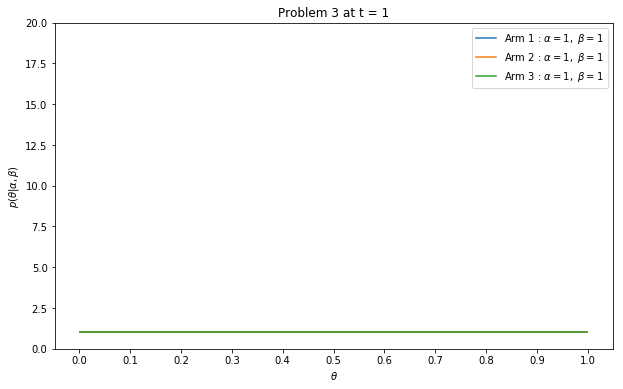

Mean at time t = 1000 is:  [ 0.47983454  0.24        0.14285714]


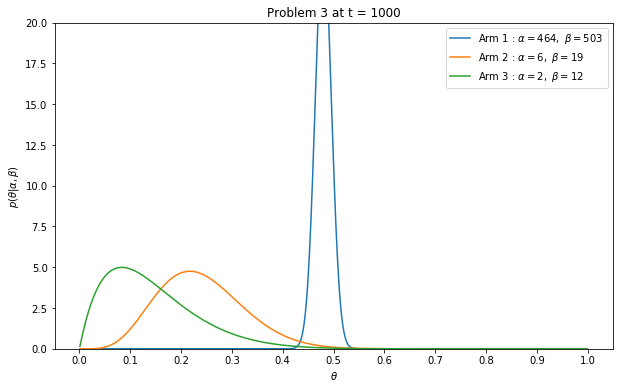

Mean at time t = 5000 is:  [ 0.5         0.25        0.11111111]


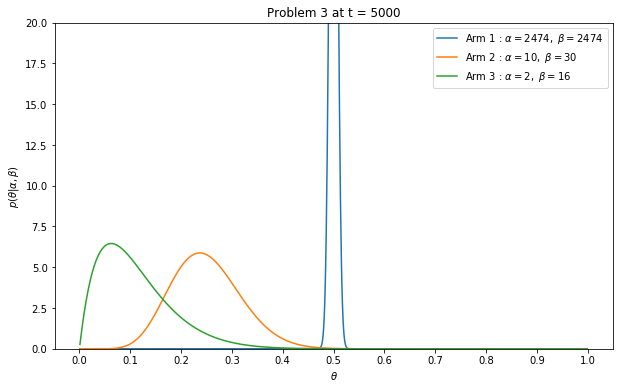

Mean at time t = 10000 is:  [ 0.49270697  0.24444444  0.10526316]


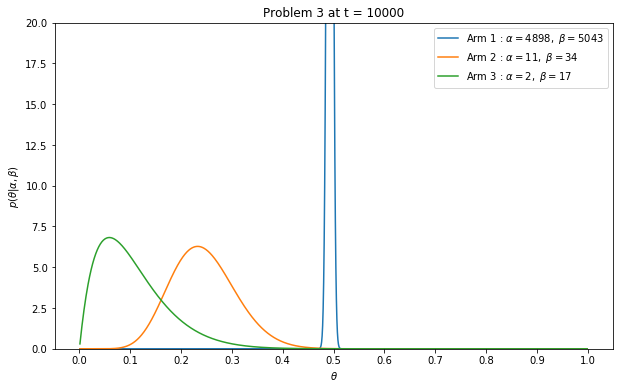

Mean at time t = 1 is:  [ 0.2  0.2  0.2]


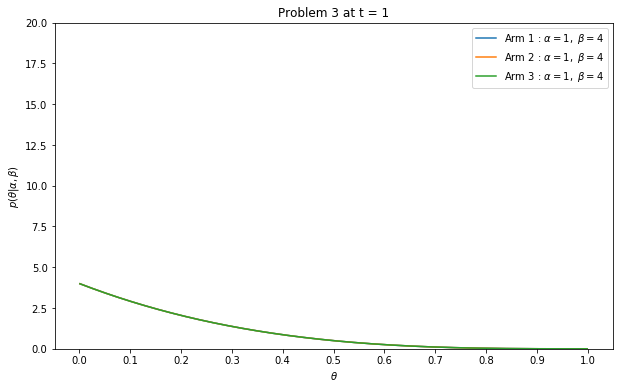

Mean at time t = 1000 is:  [ 0.509684    0.125       0.16666667]


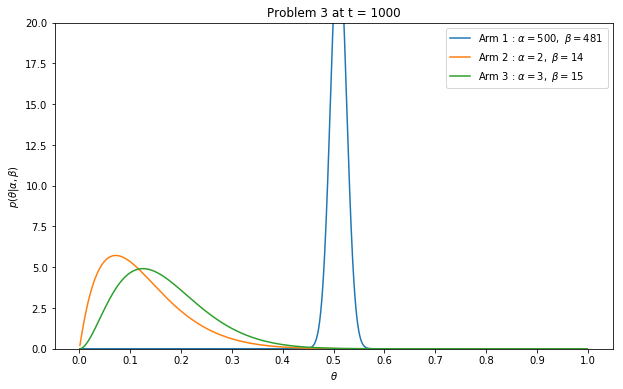

Mean at time t = 5000 is:  [ 0.50914205  0.11764706  0.14285714]


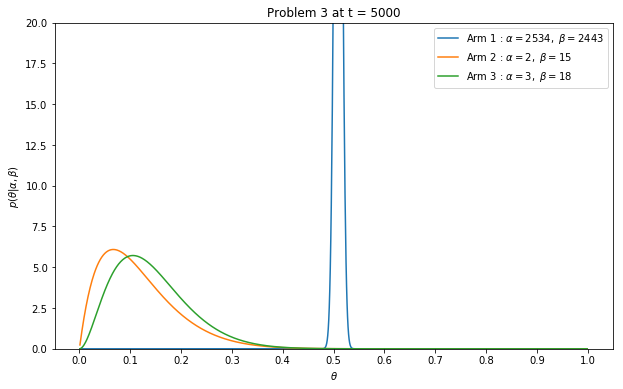

Mean at time t = 10000 is:  [ 0.51298246  0.11111111  0.14285714]


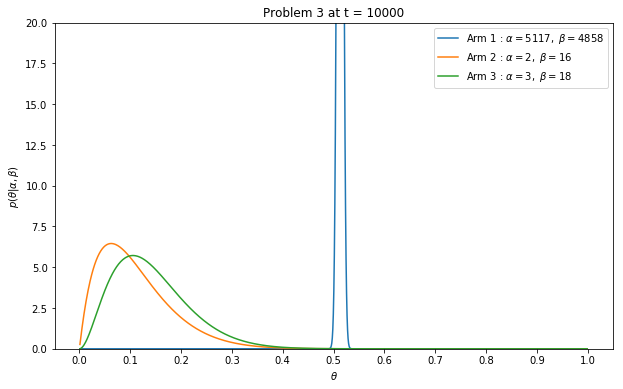

In [13]:
horizon = 10000
replications = 100

arms_prob = [[0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], [0.5, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48], [0.5, 0.2, 0.1]]
types = ['UCB','TS M0.5','TS M0.2']
m_len = len(types)
success = [1,1]
failure = [1,4]
optimalpulls = 'Cum'

for problem in range(3): # Repeating for 3 problems
    optimal_arm_pulls_sum = np.zeros([m_len,horizon]) # Storing variables returned by UCB function
    regret_per_round_sum = np.zeros([m_len,horizon])
    optimal_arm_means_stderr = np.zeros([m_len,horizon,2])
    regret_means_stderr = np.zeros([m_len,horizon,2])
    optimal_arm_percentage = np.zeros([m_len])
    total_regret = np.zeros([m_len])
    success_ret = np.zeros([2,4,len(arms_prob[problem])])
    failure_ret = np.zeros([2,4,len(arms_prob[problem])])


    regret_per_round_sum[0,:],regret_means_stderr[0,:,:], optimal_arm_pulls_sum[0,:],optimal_arm_means_stderr[0,:,:],optimal_arm_percentage[0],total_regret[0] = UCB(horizon,replications,arms_prob[problem],1,optimalpulls)
    success_ret[0,:,:],failure_ret[0,:,:],regret_per_round_sum[1,:],regret_means_stderr[1,:,:], optimal_arm_pulls_sum[1,:],optimal_arm_means_stderr[1,:,:],optimal_arm_percentage[1],total_regret[1] = TS(horizon,replications,arms_prob[problem],[success[0]]*len(arms_prob[problem]),[failure[0]]*len(arms_prob[problem]),optimalpulls)
    success_ret[1,:,:],failure_ret[1,:,:],regret_per_round_sum[2,:],regret_means_stderr[2,:,:], optimal_arm_pulls_sum[2,:],optimal_arm_means_stderr[2,:,:],optimal_arm_percentage[2],total_regret[2] = TS(horizon,replications,arms_prob[problem],[success[1]]*len(arms_prob[problem]),[failure[1]]*len(arms_prob[problem]),optimalpulls)
    

    step = 500
    print("\n")
    print("optimal_arm_percentage")
    tableIt(optimal_arm_percentage)
    print("\n")
    print("total_regret")
    tableIt(total_regret)


    # Calling function to plot % Optimal Arm Pulls Vs Time steps with error bars
    plotCumOptimalArmPulls(horizon,optimal_arm_means_stderr,optimal_arm_pulls_sum,problem,step)
    plot_arm_distribution(success_ret[0],failure_ret[0])
    plot_arm_distribution(success_ret[1],failure_ret[1])

    

In [14]:
# Saving variables
dill.dump_session(filename)


In [14]:
def get_arm_playing_prob(success,failure,trials=100):

    sample_means = np.zeros([trials,len(success)])
    arm_played_times = np.zeros(trials)
    arm_paying_prob = np.zeros(len(success))
    for i in range(len(success)):
        sample_means[:,i] = np.random.beta(success[i],failure[i],trials)
    
    for j in range(trials):
        arm_played_times[j] = np.argmax(sample_means[j,:])

    for i in range(len(success)):
        arm_paying_prob[i] = (arm_played_times == i).sum()/trials
    
    return arm_paying_prob


In [20]:
# Plotting Arm Playing Probability Vs Time steps for TS
def plot_arms_playing_prob(horizon,arm_play_Prob,problem):
    x = np.arange(horizon)
    for i in range(len(arm_play_Prob[1,:])):
        plt.plot(x,arm_play_Prob[:,i])
    plt.xlabel('Steps')
    plt.ylabel('Arm Playing Probability per step')
    if len(arm_play_Prob[1,:]) == 3:
        plt.legend(["Arm 1","Arm 2","Arm 3"],loc="best",frameon=False)
    else:
        plt.legend(["Arm 1","Arm 2","Arm 3","Arm 4","Arm 5","Arm 6","Arm 7","Arm 8","Arm 9","Arm 10"],loc=0,frameon=False)
    if problem % 2 == 0:
        plt.title("Problem 3: TS with prior mean = 0.2")
    else:
        plt.title("Problem 3: TS with prior mean = 0.5")

    plt.xlim((0,500))
    plt.ylim((0,1))
    plt.savefig('Arm_play_prob_'+str(problem)+'.png',dpi=300)
    plt.show()

 



In [16]:
# Implemention Thompson Sampling for plotting arm playing probability at each time step
def TSForPlottingArmProb(horizon,replications,arms_prob,alpha,beta,optimalpulls,problem):
    optimal_arm = 0
#     optimal_arm_pulls_per_round = np.zeros([horizon,replications])
#     regret_per_round = np.zeros([horizon,replications])
    arm_playing_prob = np.zeros([horizon,len(arms_prob)])

    savepoints = (0,1000,5000,9999)
    success_ret = np.zeros([len(savepoints),len(arms_prob)])
    faliure_ret = np.zeros([len(savepoints),len(arms_prob)])

    for r in range(replications):
        arm_pulls = [0]*len(arms_prob)
        success = np.array(alpha)
        failure = np.array(beta)
        t = 0
        s = 0
        while t < horizon:
            if t in savepoints and r == replications-1:
                success_ret[s] = success
                faliure_ret[s] = failure
                s+=1

            #Picking arm according to Posterior distribution
            sample_means = [0]*len(arms_prob)
            for i in range(len(arms_prob)):
                sample_means[i] = np.random.beta(success[i],failure[i])
            arm_selected = np.argmax(sample_means)

            arm_playing_prob[t] += get_arm_playing_prob(success,failure)

            arm_pulls[arm_selected] += 1
            temp = np.random.binomial(1, arms_prob[arm_selected])
            success[arm_selected] += temp
            failure[arm_selected] += 1 - temp

            t+=1
            
#     plot_arms_playing_prob(horizon,arm_playing_prob,problem)
    return arm_playing_prob/replications


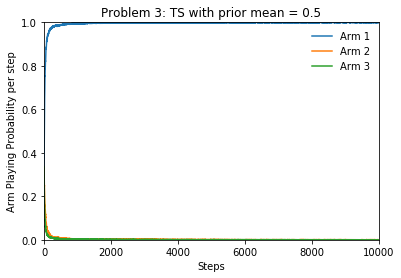

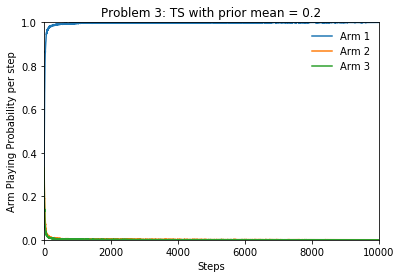

In [17]:
arm_playing_prob1 = TSForPlottingArmProb(10000,100,[0.5, 0.2, 0.1],[1,1,1],[1,1,1],'Avg',1)
plot_arms_playing_prob(10000,arm_playing_prob1,1)

arm_playing_prob2 = TSForPlottingArmProb(10000,100,[0.5, 0.2, 0.1],[1,1,1],[4,4,4],'Avg',2)
plot_arms_playing_prob(10000,arm_playing_prob2,2)



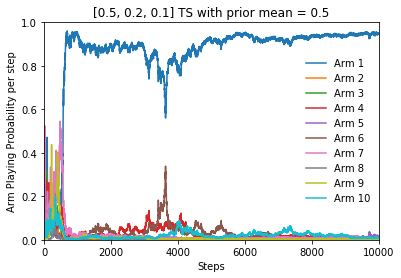

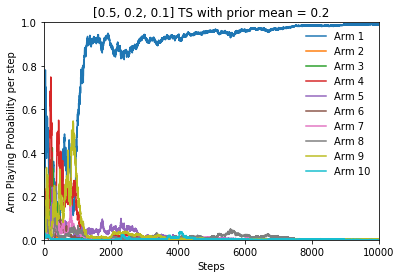

In [19]:
arm_playing_prob3 = TSForPlottingArmProb(10000,1,[0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],[1]*10,[1]*10,'Avg',3)
plot_arms_playing_prob(10000,arm_playing_prob3,3)

arm_playing_prob4 = TSForPlottingArmProb(10000,1,[0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],[1]*10,[4]*10,'Avg',3)
plot_arms_playing_prob(10000,arm_playing_prob4,4)

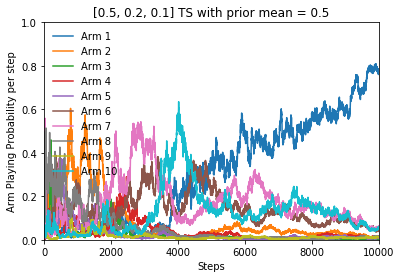

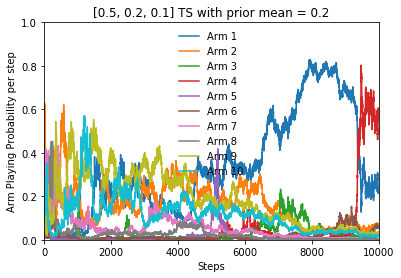

In [20]:
arm_playing_prob5 = TSForPlottingArmProb(10000,1,[0.5, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48],[1]*10,[1]*10,'Avg',3)
plot_arms_playing_prob(10000,arm_playing_prob5,5)

arm_playing_prob6 = TSForPlottingArmProb(10000,1,[0.5, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48, 0.48],[1]*10,[4]*10,'Avg',3)
plot_arms_playing_prob(10000,arm_playing_prob6,6)

In [21]:
dill.dump_session(filename)


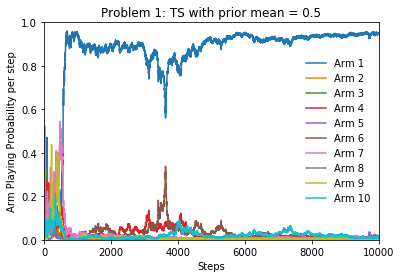

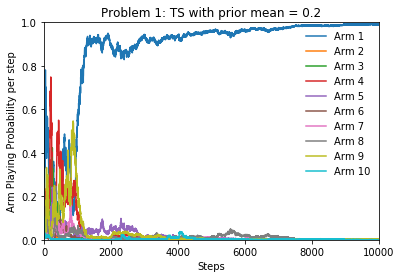

In [23]:
plot_arms_playing_prob(10000,arm_playing_prob3,3)
plot_arms_playing_prob(10000,arm_playing_prob4,4)

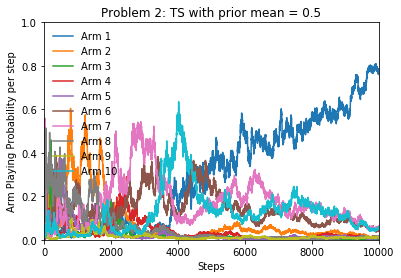

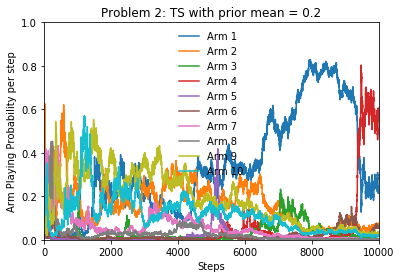

In [25]:
plot_arms_playing_prob(10000,arm_playing_prob5,5)
plot_arms_playing_prob(10000,arm_playing_prob6,6)

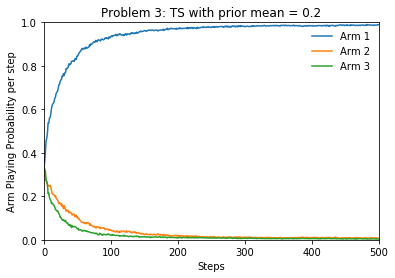

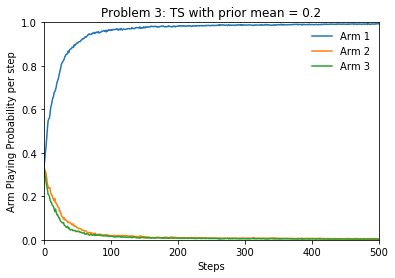

In [21]:
plot_arms_playing_prob(10000,arm_playing_prob1,10)
plot_arms_playing_prob(10000,arm_playing_prob2,20)


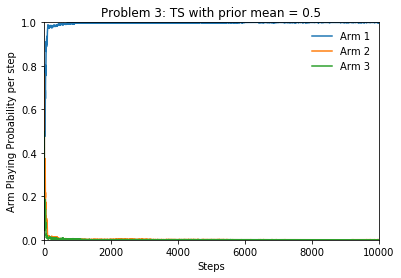

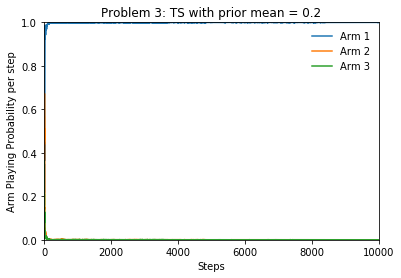

In [32]:
plot_arms_playing_prob(10000,arm_playing_prob1,1)
plot_arms_playing_prob(10000,arm_playing_prob2,2)
